<a href="https://colab.research.google.com/github/ifozmen/EB_Processing_Timelines/blob/main/EB_current_date_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EB Visa Priority Date Analysis Tool

## Quick Start Guide for Google Colab

### What this notebook does:
- Analyzes EB (Employment-Based) visa bulletin data from travel.state.gov
- Tracks Final Action Date movements over time
- Predicts when your priority date might become current
- Generates comprehensive Excel reports and visualization charts

### How to use:
1. **No setup required!** Just run the cells in order
2. The first cell installs all required packages automatically
3. Modify parameters in the last cell to analyze your specific case
4. Download results automatically

### Supported Options:
- **Categories:** EB-1, EB-2, EB-3, EB-4
- **Countries:** India, China, Mexico, Philippines, ROW (Rest of World)
- **Custom priority dates and analysis periods**

---

**Ready to begin? Run the cells below! ⬇️**

In [ ]:
# Install and Import Dependencies (with Colab file handling)

from typing import List, Union, Optional, Dict
import os
import re
import sys
import subprocess
from datetime import datetime
import importlib
try:
    from google.colab import files
    IN_COLAB = True
    print('✅ Running in Google Colab')
except ImportError:
    IN_COLAB = False
    print('ℹ️  Running in local environment')

BASE_URL = "https://travel.state.gov/content/travel/en/legal/visa-law0/visa-bulletin.html"
SUPPORTED_CATEGORIES = ['1','2','3','4']  # EB-1..EB-4
SUPPORTED_COUNTRIES = ['india','china','mexico','philippines','row']
DEFAULT_CATEGORY = '2'      # EB-2
DEFAULT_COUNTRY = 'row'     # Rest of World
DEFAULT_MONTHS_BACK = 60
DEFAULT_OUTPUT_DIR = '/content/visa_analysis_output' if IN_COLAB else os.path.join(os.getcwd(), 'tmp')

required = {
    'requests': 'requests',
    'bs4': 'beautifulsoup4',
    'lxml': 'lxml',
    'pandas': 'pandas',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'numpy': 'numpy',
    'openpyxl': 'openpyxl',
    'xlsxwriter': 'xlsxwriter',
    'dateutil': 'python-dateutil',
}

print('🔍 Checking dependencies...')
missing = []
for mod, pkg in required.items():
    try:
        importlib.import_module(mod)
    except Exception:
        missing.append(pkg)

if missing:
    print(f'📦 Installing: {", ".join(sorted(set(missing)))}')
    result = subprocess.run(
        [sys.executable, '-m', 'pip', 'install', '-q', *sorted(set(missing))],
        capture_output=True, text=True
    )
    if result.returncode != 0:
        print('⚠️  Warning: pip installation encountered an issue.')
        if result.stderr:
            print(result.stderr[-1000:])
    else:
        print('✅ Dependencies installed successfully')
else:
    print('✅ All dependencies already available')

failed = []
for mod in required.keys():
    try:
        importlib.import_module(mod)
    except Exception as e:
        failed.append((mod, str(e)))

if failed:
    print('❌ The following modules are unavailable:')
    for mod, msg in failed:
        print(f'   - {mod}: {msg}')
    raise SystemExit('Dependency check failed')
else:
    print('✅ All dependencies verified')

import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('\n🎉 Setup complete! Ready to analyze visa bulletins.')
if IN_COLAB:
    print('💾 Files will be automatically downloaded to your PC after analysis.')

✅ Running in Google Colab
🔍 Checking dependencies...
✅ All dependencies already available
✅ All dependencies verified

🎉 Setup complete! Ready to analyze visa bulletins.
💾 Files will be automatically downloaded to your PC after analysis.


In [ ]:
# Core Analysis Functions

def extract_datetime_from_link(link: str) -> Union[None, datetime]:
    pattern = r'visa-bulletin-for-(\w+)-(\d{4})\.html$'
    match = re.search(pattern, link)
    if not match:
        return None
    month_str, year = match.groups()
    month_map = {
        'january': 1, 'february': 2, 'march': 3, 'april': 4,
        'may': 5, 'june': 6, 'july': 7, 'august': 8,
        'september': 9, 'october': 10, 'november': 11, 'december': 12
    }
    month = month_map.get(month_str.lower())
    if not month:
        return None
    return datetime(year=int(year), month=month, day=1)

def get_soup(url: str) -> BeautifulSoup:
    response = requests.get(url)
    response.raise_for_status()
    return BeautifulSoup(response.text, 'html.parser')

def extract_month_links() -> List[str]:
    soup = get_soup(BASE_URL)
    month_links: List[str] = []
    accordion_sections = soup.find_all('div', class_='accordion parbase section')
    for section in accordion_sections:
        link_container = section.find('div', class_='tsg-rwd-accordion-copy')
        if link_container:
            links = link_container.find_all('a', href=True)
            for link in links:
                month_links.append(link['href'])
    return month_links

def extract_tables(link: str) -> List[pd.DataFrame]:
    year_month = extract_datetime_from_link(link)
    soup = get_soup('https://travel.state.gov/' + link)
    tables = soup.find_all('table')
    dfs: List[pd.DataFrame] = []
    for table in tables:
        rows = table.find_all('tr')
        if any("employment-based" in row.get_text(strip=True).lower() for row in rows):
            table_data = []
            for row in rows:
                th_cols = row.find_all('th')
                td_cols = row.find_all('td')
                all_cols = th_cols + td_cols
                cols = [ele.text.strip() for ele in all_cols]
                table_data.append(cols)
            if len(table_data[0]) == 1:
                columns = table_data[1]
                table_body = table_data[2:]
            else:
                columns = table_data[0]
                table_body = table_data[1:]
            df = pd.DataFrame(table_body, columns=columns)
            df['visa_bulletin_date'] = year_month
            df.columns = df.columns.str.replace('\n', '').str.replace('- ', '-')
            df.columns = df.columns.str.lower()
            dfs.append(df)
            break
    return dfs

def string_to_datetime(date_str: str, bulletin_date: datetime) -> Union[None, datetime]:
    if date_str == 'C':
        return bulletin_date
    elif date_str == 'U':
        return None
    elif pd.isna(date_str):
        return None
    try:
        return datetime.strptime(date_str, '%d%b%y')
    except ValueError:
        return None

def normalize_country_key(country: str) -> str:
    c = country.strip().lower()
    mapping = {
        'row': 'all chargeability  areas except those listed',
        'india': 'india',
        'china': 'china-mainland born',
        'mexico': 'mexico',
        'philippines': 'philippines',
    }
    return mapping.get(c, c)

def extract_country_data(country: str, all_data: List[pd.DataFrame]) -> pd.DataFrame:
    tgt_label = normalize_country_key(country)
    country_data: List[pd.DataFrame] = []
    for df in all_data:
        df.columns = [column.replace('\xa0', ' ') for column in df.columns]
        if any([tgt_label in col for col in df.columns]):
            col_idx = [i for i, col in enumerate(df.columns) if tgt_label in col][0]
            country_col = df.columns[col_idx]
            try:
                df2 = df[['employment-based', country_col, 'visa_bulletin_date']].copy()
                df2.columns = df2.columns.str.replace(country_col, 'final_action_dates')
                df2.columns = df2.columns.str.replace('employment-based', 'EB_level')
                country_data.append(df2)
            except Exception:
                pass
    if not country_data:
        return pd.DataFrame(columns=['EB_level','final_action_dates','visa_bulletin_date','visa_wait_time'])
    country_df = pd.concat(country_data, axis=0, ignore_index=True)
    country_df['final_action_dates'] = country_df.apply(
        lambda row: string_to_datetime(row['final_action_dates'], row['visa_bulletin_date']), axis=1)
    country_df['visa_wait_time'] = country_df.apply(
        lambda row: (row['visa_bulletin_date'] - row['final_action_dates']).days / 365.25
        if row['final_action_dates'] else None, axis=1)
    country_df['EB_level'] = (country_df['EB_level']
        .str.replace('st', '')
        .str.replace('nd', '')
        .str.replace('rd', '')
        .str.replace('th', ''))
    country_df = country_df[country_df['EB_level'].isin(SUPPORTED_CATEGORIES)]
    return country_df

def download_results(excel_file: str, chart_file: str):
    """Download generated files to local PC if running in Colab"""
    if IN_COLAB:
        print('\n📥 Downloading files to your computer...')
        try:
            if os.path.exists(excel_file):
                files.download(excel_file)
                print(f'   ✅ Downloaded: {os.path.basename(excel_file)}')
            if os.path.exists(chart_file):
                files.download(chart_file)
                print(f'   ✅ Downloaded: {os.path.basename(chart_file)}')
            print('✅ All files downloaded successfully!')
        except Exception as e:
            print(f'⚠️  Download error: {e}')
            print('💡 You can manually download from the Files panel (📁 icon on left)')
    else:
        print(f'\n💾 Files saved locally:')
        print(f'   • {excel_file}')
        print(f'   • {chart_file}')

print('✅ Functions loaded successfully')

def run_eb_analysis(category: Optional[str] = None, country: Optional[str] = None,
                    priority_date: Optional[Union[str, datetime]] = None,
                    output_dir: Optional[str] = None, months_back: int = DEFAULT_MONTHS_BACK) -> Dict[str, object]:
    if category is None:
        category = DEFAULT_CATEGORY
    if country is None:
        country = DEFAULT_COUNTRY
    if priority_date is None:
        priority_date = datetime.now()

    if category not in SUPPORTED_CATEGORIES:
        raise ValueError(f"Unsupported EB category: {category}")
    if country.lower() not in SUPPORTED_COUNTRIES:
        raise ValueError(f"Unsupported country: {country}")
    if isinstance(priority_date, str):
        priority_date_dt = datetime.strptime(priority_date, '%Y-%m-%d')
    else:
        priority_date_dt = priority_date

    out_dir = output_dir or DEFAULT_OUTPUT_DIR
    os.makedirs(out_dir, exist_ok=True)

    print(f'📊 Analyzing EB-{category} for {country.upper()}...')
    print(f'📅 Priority Date: {priority_date_dt.strftime("%B %d, %Y")}')
    print(f'🔄 Fetching visa bulletins...')

    month_links = extract_month_links()
    cutoff_date = datetime.now() - relativedelta(months=months_back)
    recent_links = []
    for link in month_links:
        dt = extract_datetime_from_link(link)
        if dt and dt >= cutoff_date:
            recent_links.append(link)
    recent_links = recent_links[:months_back]

    all_data: List[pd.DataFrame] = []
    for i, link in enumerate(recent_links, 1):
        try:
            table_data = extract_tables(link)
            all_data.extend(table_data)
            if i % 10 == 0:
                print(f'   Processed {i}/{len(recent_links)} bulletins...')
        except Exception:
            continue

    print(f'✅ Retrieved {len(all_data)} visa bulletins')
    print(f'📈 Processing data...')

    country_df = extract_country_data(country, all_data).sort_values(by='visa_bulletin_date', ascending=True)
    if country_df.empty:
        raise ValueError(f"No data extracted for {country}")

    eb_df = country_df[country_df['EB_level'] == category].copy().reset_index(drop=True)
    eb_df = eb_df.dropna(subset=['final_action_dates'])
    if eb_df.empty:
        raise ValueError(f"No EB-{category} rows for {country}")

    eb_sorted = eb_df.sort_values('visa_bulletin_date').copy()
    eb_sorted['days_moved'] = eb_sorted['final_action_dates'].diff().dt.days
    eb_sorted['months_moved'] = eb_sorted['days_moved'] / 30.44
    avg_movement = eb_sorted['months_moved'].mean()
    median_movement = eb_sorted['months_moved'].median()
    recent_6mo_movement = eb_sorted['months_moved'].tail(6).mean()
    recent_12mo_movement = eb_sorted['months_moved'].tail(12).mean()
    recent_24mo_movement = eb_sorted['months_moved'].tail(24).mean()
    current_bulletin = eb_sorted.iloc[-1]
    current_bulletin_date = current_bulletin['visa_bulletin_date']
    current_final_action = current_bulletin['final_action_dates']

    print(f'💾 Generating Excel report...')
    excel_file = os.path.join(out_dir, f'eb{category}_{country.lower()}_analysis.xlsx')
    with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
        workbook = writer.book
        header_format = workbook.add_format({
            'bold': True, 'bg_color': '#2C5F7C', 'font_color': 'white',
            'align': 'center', 'valign': 'vcenter', 'border': 1
        })
        date_format = workbook.add_format({'num_format': 'mmm dd, yyyy', 'align': 'center'})
        number_format = workbook.add_format({'num_format': '0.00', 'align': 'center'})

        eb_sorted.to_excel(writer, sheet_name='Historical_Data', index=False)
        ws1 = writer.sheets['Historical_Data']
        for col_num, val in enumerate(eb_sorted.columns.values):
            ws1.write(0, col_num, val, header_format)
        ws1.set_column('A:A', 15)
        ws1.set_column('B:B', 18, date_format)
        ws1.set_column('C:C', 18, date_format)
        ws1.set_column('D:F', 15, number_format)

        summary_stats = pd.DataFrame({
            'Metric': [
                'Priority Date', 'Latest Visa Bulletin', 'Current Final Action Date',
                'Current Wait Time (Years)', '', 'Total Bulletins Analyzed',
                'Data Start Date', 'Data End Date', '', 'Average Movement (All Time)',
                'Median Movement (All Time)', '6-Month Average Movement',
                '12-Month Average Movement', '24-Month Average Movement', '',
                'Minimum Monthly Movement', 'Maximum Monthly Movement', 'Standard Deviation', '',
                'Average Wait Time (Historical)', 'Minimum Wait Time', 'Maximum Wait Time'
            ],
            'Value': [
                priority_date_dt.strftime('%B %d, %Y'),
                current_bulletin_date.strftime('%B %Y'),
                current_final_action.strftime('%B %d, %Y'),
                f"{current_bulletin['visa_wait_time']:.2f}", '', len(eb_sorted),
                eb_sorted['visa_bulletin_date'].min().strftime('%B %Y'),
                eb_sorted['visa_bulletin_date'].max().strftime('%B %Y'), '',
                f"{avg_movement:.2f} months", f"{median_movement:.2f} months",
                f"{recent_6mo_movement:.2f} months", f"{recent_12mo_movement:.2f} months",
                f"{recent_24mo_movement:.2f} months", '',
                f"{eb_sorted['months_moved'].min():.2f} months",
                f"{eb_sorted['months_moved'].max():.2f} months",
                f"{eb_sorted['months_moved'].std():.2f} months", '',
                f"{eb_sorted['visa_wait_time'].mean():.2f} years",
                f"{eb_sorted['visa_wait_time'].min():.2f} years",
                f"{eb_sorted['visa_wait_time'].max():.2f} years"
            ]
        })
        summary_stats.to_excel(writer, sheet_name='Summary_Statistics', index=False)
        ws2 = writer.sheets['Summary_Statistics']
        for col_num, val in enumerate(summary_stats.columns.values):
            ws2.write(0, col_num, val, header_format)
        ws2.set_column('A:A', 35)
        ws2.set_column('B:B', 25)

        if current_final_action < priority_date_dt:
            days_gap = (priority_date_dt - current_final_action).days
            months_gap = days_gap / 30.44
            projections = []
            if recent_6mo_movement and recent_6mo_movement > 0:
                bulletins_6mo = months_gap / recent_6mo_movement
                est_date_6mo = current_bulletin_date + relativedelta(months=int(bulletins_6mo))
                projections.append({
                    'Scenario': '6-Month Trend',
                    'Movement Rate (months/bulletin)': f"{recent_6mo_movement:.2f}",
                    'Bulletins Needed': f"{bulletins_6mo:.1f}",
                    'Time Needed (months)': f"{bulletins_6mo:.1f}",
                    'Time Needed (years)': f"{bulletins_6mo/12:.2f}",
                    'Estimated Current Date': est_date_6mo.strftime('%B %Y'),
                    'Estimated Year': est_date_6mo.year
                })
            if recent_12mo_movement and recent_12mo_movement > 0:
                bulletins_12mo = months_gap / recent_12mo_movement
                est_date_12mo = current_bulletin_date + relativedelta(months=int(bulletins_12mo))
                projections.append({
                    'Scenario': '12-Month Trend',
                    'Movement Rate (months/bulletin)': f"{recent_12mo_movement:.2f}",
                    'Bulletins Needed': f"{bulletins_12mo:.1f}",
                    'Time Needed (months)': f"{bulletins_12mo:.1f}",
                    'Time Needed (years)': f"{bulletins_12mo/12:.2f}",
                    'Estimated Current Date': est_date_12mo.strftime('%B %Y'),
                    'Estimated Year': est_date_12mo.year
                })
            if recent_24mo_movement and recent_24mo_movement > 0:
                bulletins_24mo = months_gap / recent_24mo_movement
                est_date_24mo = current_bulletin_date + relativedelta(months=int(bulletins_24mo))
                projections.append({
                    'Scenario': '24-Month Trend',
                    'Movement Rate (months/bulletin)': f"{recent_24mo_movement:.2f}",
                    'Bulletins Needed': f"{bulletins_24mo:.1f}",
                    'Time Needed (months)': f"{bulletins_24mo:.1f}",
                    'Time Needed (years)': f"{bulletins_24mo/12:.2f}",
                    'Estimated Current Date': est_date_24mo.strftime('%B %Y'),
                    'Estimated Year': est_date_24mo.year
                })
            if avg_movement and avg_movement > 0:
                bulletins_avg = months_gap / avg_movement
                est_date_avg = current_bulletin_date + relativedelta(months=int(bulletins_avg))
                projections.append({
                    'Scenario': 'Historical Average',
                    'Movement Rate (months/bulletin)': f"{avg_movement:.2f}",
                    'Bulletins Needed': f"{bulletins_avg:.1f}",
                    'Time Needed (months)': f"{bulletins_avg:.1f}",
                    'Time Needed (years)': f"{bulletins_avg/12:.2f}",
                    'Estimated Current Date': est_date_avg.strftime('%B %Y'),
                    'Estimated Year': est_date_avg.year
                })
            projections_df = pd.DataFrame(projections)
            projections_df.to_excel(writer, sheet_name='Projections', index=False)
            ws3 = writer.sheets['Projections']
            for col_num, val in enumerate(projections_df.columns.values):
                ws3.write(0, col_num, val, header_format)
            ws3.set_column('A:A', 20)
            ws3.set_column('B:E', 18)
            ws3.set_column('F:F', 22)
            ws3.set_column('G:G', 15)

        movement_details = eb_sorted[['visa_bulletin_date', 'final_action_dates', 'months_moved', 'visa_wait_time']].copy()
        movement_details.to_excel(writer, sheet_name='Monthly_Movement', index=False)
        ws4 = writer.sheets['Monthly_Movement']
        for col_num, val in enumerate(movement_details.columns.values):
            ws4.write(0, col_num, val, header_format)
        ws4.set_column('A:B', 18, date_format)
        ws4.set_column('C:D', 18, number_format)

    print(f'📊 Creating visualization...')
    # Figure (8-panel)
    fig = plt.figure(figsize=(28, 32))
    gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.25)
    if current_final_action < priority_date_dt:
        months_to_cover = (priority_date_dt - current_final_action).days / 30.44
        days_gap = (priority_date_dt - current_final_action).days
    # Panel 1
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(eb_sorted['visa_bulletin_date'], eb_sorted['final_action_dates'], marker='o', linewidth=2.5, markersize=5, label='Final Action Date', color='steelblue')
    ax1.axhline(y=priority_date_dt, color='red', linestyle='--', linewidth=3, label=f'Priority Date ({priority_date_dt.strftime("%b %d, %Y")})', alpha=0.8)
    ax1.axvline(x=current_bulletin_date, color='green', linestyle=':', linewidth=2, label=f'Current Bulletin ({current_bulletin_date.strftime("%b %Y")})', alpha=0.7)
    ax1.set_xlabel('Visa Bulletin Date', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Final Action Date', fontsize=12, fontweight='bold')
    ax1.set_title(f'1. EB-{category} {country.upper()} Final Action Movement', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10, loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45, labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    # Panel 2
    ax2 = fig.add_subplot(gs[0, 1])
    colors = ['green' if x > 0 else 'red' for x in eb_sorted['months_moved'][1:]]
    ax2.bar(eb_sorted['visa_bulletin_date'][1:], eb_sorted['months_moved'][1:], width=20, alpha=0.7, color=colors, edgecolor='black', linewidth=0.5)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax2.axhline(y=avg_movement, color='blue', linestyle='--', linewidth=2, label=f'All-time Avg: {avg_movement:.1f}mo', alpha=0.7)
    ax2.axhline(y=recent_6mo_movement, color='red', linestyle='--', linewidth=2, label=f'6-mo Avg: {recent_6mo_movement:.1f}mo', alpha=0.7)
    ax2.axhline(y=recent_12mo_movement, color='orange', linestyle='--', linewidth=2, label=f'12-mo Avg: {recent_12mo_movement:.1f}mo', alpha=0.7)
    ax2.axhline(y=recent_24mo_movement, color='green', linestyle='--', linewidth=2, label=f'24-mo Avg: {recent_24mo_movement:.1f}mo', alpha=0.7)
    ax2.set_xlabel('Visa Bulletin Date', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Months Moved Forward', fontsize=12, fontweight='bold')
    ax2.set_title('2. Monthly Movement Rate with Trend Lines', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=9, loc='best')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=45, labelsize=10)
    ax2.tick_params(axis='y', labelsize=10)
    # Panel 3
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(eb_sorted['visa_bulletin_date'], eb_sorted['visa_wait_time'], marker='s', linewidth=2.5, markersize=5, color='darkgreen', label='Wait Time (Years)')
    avg_wait = eb_sorted['visa_wait_time'].mean()
    ax3.axhline(y=avg_wait, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_wait:.2f} years', alpha=0.7)
    ax3.set_xlabel('Visa Bulletin Date', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Wait Time (Years)', fontsize=12, fontweight='bold')
    ax3.set_title('3. Visa Wait Time Trend', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45, labelsize=10)
    ax3.tick_params(axis='y', labelsize=10)
    # Panel 4
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.hist(eb_sorted['months_moved'].dropna(), bins=30, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
    ax4.axvline(x=median_movement, color='red', linestyle='--', linewidth=2.5, label=f'Median: {median_movement:.1f}mo')
    ax4.axvline(x=avg_movement, color='orange', linestyle='--', linewidth=2.5, label=f'Mean: {avg_movement:.1f}mo')
    ax4.set_xlabel('Months Moved per Bulletin', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax4.set_title('4. Movement Distribution', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.tick_params(labelsize=10)
    # Panel 5
    ax5 = fig.add_subplot(gs[2, 0])
    recent_24 = eb_sorted.tail(24)
    ax5.plot(recent_24['visa_bulletin_date'], recent_24['months_moved'], marker='o', linewidth=3, markersize=7, color='darkorange', label='Monthly Movement')
    ax5.axhline(y=recent_24mo_movement, color='blue', linestyle='--', linewidth=2.5, label=f'24-mo Avg: {recent_24mo_movement:.1f}mo')
    ax5.axhline(y=recent_12mo_movement, color='green', linestyle='--', linewidth=2.5, label=f'12-mo Avg: {recent_12mo_movement:.1f}mo')
    ax5.axhline(y=recent_6mo_movement, color='red', linestyle='--', linewidth=2.5, label=f'6-mo Avg: {recent_6mo_movement:.1f}mo')
    ax5.set_xlabel('Visa Bulletin Date', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Months Moved', fontsize=12, fontweight='bold')
    ax5.set_title('5. Recent Movement Trends (Last 24 Months)', fontsize=14, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)
    ax5.tick_params(axis='x', rotation=45, labelsize=10)
    ax5.tick_params(axis='y', labelsize=10)
    # Panel 6
    ax6 = fig.add_subplot(gs[2, 1])
    eb_sorted['year'] = eb_sorted['visa_bulletin_date'].dt.year
    yearly_movement = eb_sorted.groupby('year')['months_moved'].mean()
    ax6.bar(yearly_movement.index, yearly_movement.values, alpha=0.7, color='teal', edgecolor='black', linewidth=0.8)
    ax6.axhline(y=avg_movement, color='red', linestyle='--', linewidth=2.5, label=f'Overall Avg: {avg_movement:.1f}mo')
    ax6.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Avg Monthly Movement', fontsize=12, fontweight='bold')
    ax6.set_title('6. Year-over-Year Average Movement', fontsize=14, fontweight='bold')
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.tick_params(labelsize=10)
    # Panel 7
    ax7 = fig.add_subplot(gs[3, 0])
    if current_final_action < priority_date_dt:
        recent_12 = eb_sorted.tail(12)
        ax7.plot(recent_12['visa_bulletin_date'], recent_12['final_action_dates'], marker='o', linewidth=3, markersize=7, label='Recent History', color='steelblue')
        ax7.axhline(y=priority_date_dt, color='red', linestyle='--', linewidth=3, label=f'Priority Date', alpha=0.8)
        if recent_6mo_movement and recent_6mo_movement > 0:
            bulletins_6mo = int(months_to_cover / recent_6mo_movement) + 1
            future_dates_6mo = [current_bulletin_date + relativedelta(months=i) for i in range(min(bulletins_6mo + 1, 25))]
            future_actions_6mo = [current_final_action + relativedelta(months=int(i * recent_6mo_movement)) for i in range(min(bulletins_6mo + 1, 25))]
            ax7.plot(future_dates_6mo, future_actions_6mo, '--', linewidth=3, label=f'6-mo Trend (~{bulletins_6mo:.0f}mo)', alpha=0.8, color='orange')
        if recent_12mo_movement and recent_12mo_movement > 0:
            bulletins_12mo = int(months_to_cover / recent_12mo_movement) + 1
            future_dates_12mo = [current_bulletin_date + relativedelta(months=i) for i in range(min(bulletins_12mo + 1, 25))]
            future_actions_12mo = [current_final_action + relativedelta(months=int(i * recent_12mo_movement)) for i in range(min(bulletins_12mo + 1, 25))]
            ax7.plot(future_dates_12mo, future_actions_12mo, '--', linewidth=3, label=f'12-mo Trend (~{bulletins_12mo:.0f}mo)', alpha=0.8, color='green')
        if recent_24mo_movement and recent_24mo_movement > 0:
            bulletins_24mo = int(months_to_cover / recent_24mo_movement) + 1
            future_dates_24mo = [current_bulletin_date + relativedelta(months=i) for i in range(min(bulletins_24mo + 1, 25))]
            future_actions_24mo = [current_final_action + relativedelta(months=int(i * recent_24mo_movement)) for i in range(min(bulletins_24mo + 1, 25))]
            ax7.plot(future_dates_24mo, future_actions_24mo, '--', linewidth=3, label=f'24-mo Trend (~{bulletins_24mo:.0f}mo)', alpha=0.8, color='purple')
        ax7.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax7.set_ylabel('Final Action Date', fontsize=12, fontweight='bold')
        ax7.set_title('7. WHEN WILL YOU BE CURRENT?', fontsize=14, fontweight='bold', color='darkred')
        ax7.legend(fontsize=10, loc='best')
        ax7.grid(True, alpha=0.3)
        ax7.tick_params(axis='x', rotation=45, labelsize=10)
        ax7.tick_params(axis='y', labelsize=10)
    else:
        ax7.text(0.5, 0.5, '✓ PRIORITY DATE\nIS ALREADY CURRENT!', ha='center', va='center', fontsize=24, fontweight='bold', color='green', transform=ax7.transAxes)
        ax7.set_title('7. ⭐ CURRENT STATUS ⭐', fontsize=14, fontweight='bold', color='darkgreen')
        ax7.axis('off')
    # Panel 8
    ax8 = fig.add_subplot(gs[3, 1])
    ax8.axis('off')
    if current_final_action < priority_date_dt:
        table_data = [
            ['METRIC', 'VALUE'],
            ['', ''],
            ['Priority Date', priority_date_dt.strftime('%B %d, %Y')],
            ['Current Final Action', current_final_action.strftime('%B %d, %Y')],
            ['Gap to Cover', f'{days_gap} days ({months_to_cover:.1f} months)'],
            ['', ''],
            ['ESTIMATED CURRENT DATES', ''],
            ['6-Month Trend', f"{(current_bulletin_date + relativedelta(months=int(((priority_date_dt - current_final_action).days / 30.44) / max(recent_6mo_movement, 1e-9)))).strftime('%B %Y')}" if recent_6mo_movement and recent_6mo_movement > 0 else 'N/A'],
            ['12-Month Trend', f"{(current_bulletin_date + relativedelta(months=int(((priority_date_dt - current_final_action).days / 30.44) / max(recent_12mo_movement, 1e-9)))).strftime('%B %Y')}" if recent_12mo_movement and recent_12mo_movement > 0 else 'N/A'],
            ['24-Month Trend', f"{(current_bulletin_date + relativedelta(months=int(((priority_date_dt - current_final_action).days / 30.44) / max(recent_24mo_movement, 1e-9)))).strftime('%B %Y')}" if recent_24mo_movement and recent_24mo_movement > 0 else 'N/A'],
            ['', ''],
            ['MOVEMENT STATISTICS', ''],
            ['6-Month Avg', f'{recent_6mo_movement:.2f} months/bulletin'],
            ['12-Month Avg', f'{recent_12mo_movement:.2f} months/bulletin'],
            ['24-Month Avg', f'{recent_24mo_movement:.2f} months/bulletin'],
            ['All-Time Avg', f'{avg_movement:.2f} months/bulletin'],
        ]
    else:
        table_data = [
            ['CURRENT STATUS', 'DETAILS'],
            ['━' * 30, '━' * 40],
            ['Priority Date', priority_date_dt.strftime('%B %d, %Y')],
            ['Current Final Action', current_final_action.strftime('%B %d, %Y')],
            ['Status', '✅ CURRENT - You may file AOS!'],
        ]
    table = ax8.table(cellText=table_data, cellLoc='left', loc='center', colWidths=[0.5, 0.5], bbox=[0.05, 0.1, 0.9, 0.85])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    for i, row in enumerate(table_data):
        for j in range(2):
            cell = table[(i, j)]
            if i == 0:
                cell.set_facecolor('#2C5F7C')
                cell.set_text_props(weight='bold', size=12, color='white')
            elif '━' in str(row[0]):
                cell.set_facecolor('#D0D0D0')
            elif 'ESTIMATED' in str(row[0]) or 'MOVEMENT' in str(row[0]):
                cell.set_facecolor('#E6F3FF')
                cell.set_text_props(weight='bold', size=11)
            elif 'CURRENT' in str(row[1]) or '✅' in str(row[1]):
                cell.set_facecolor('#CCFFCC')
                cell.set_text_props(weight='bold', size=12, color='darkgreen')
            else:
                cell.set_facecolor('#F9F9F9')
            cell.set_edgecolor('gray')
            cell.set_linewidth(1)

    fig.suptitle(f'EB-{category} {country.upper()} - Comprehensive Visa Priority Date Analysis\nPriority Date: {priority_date_dt.strftime("%B %d, %Y")} | Latest Bulletin: {current_bulletin_date.strftime("%B %Y")}', fontsize=20, fontweight='bold', y=0.995)
    chart_file = os.path.join(out_dir, f'eb{category}_{country.lower()}_chart.png')
    plt.savefig(chart_file, dpi=600, bbox_inches='tight')
    plt.show()

    print(f'\n✅ Analysis complete!')
    print(f'📁 Files saved to: {out_dir}')
    print(f'   • Excel: {os.path.basename(excel_file)}')
    print(f'   • Chart: {os.path.basename(chart_file)}')

    download_results(excel_file, chart_file)

    return {
        'excel_file': excel_file,
        'chart_file': chart_file,
        'current_bulletin_date': current_bulletin_date,
        'current_final_action': current_final_action
    }

✅ Functions loaded successfully


🚀 STARTING EB VISA ANALYSIS
📊 Analyzing EB-2 for ROW...
📅 Priority Date: November 25, 2025
🔄 Fetching visa bulletins...
   Processed 10/60 bulletins...
   Processed 30/60 bulletins...
   Processed 40/60 bulletins...
   Processed 50/60 bulletins...
   Processed 60/60 bulletins...
✅ Retrieved 59 visa bulletins
📈 Processing data...
💾 Generating Excel report...
📊 Creating visualization...


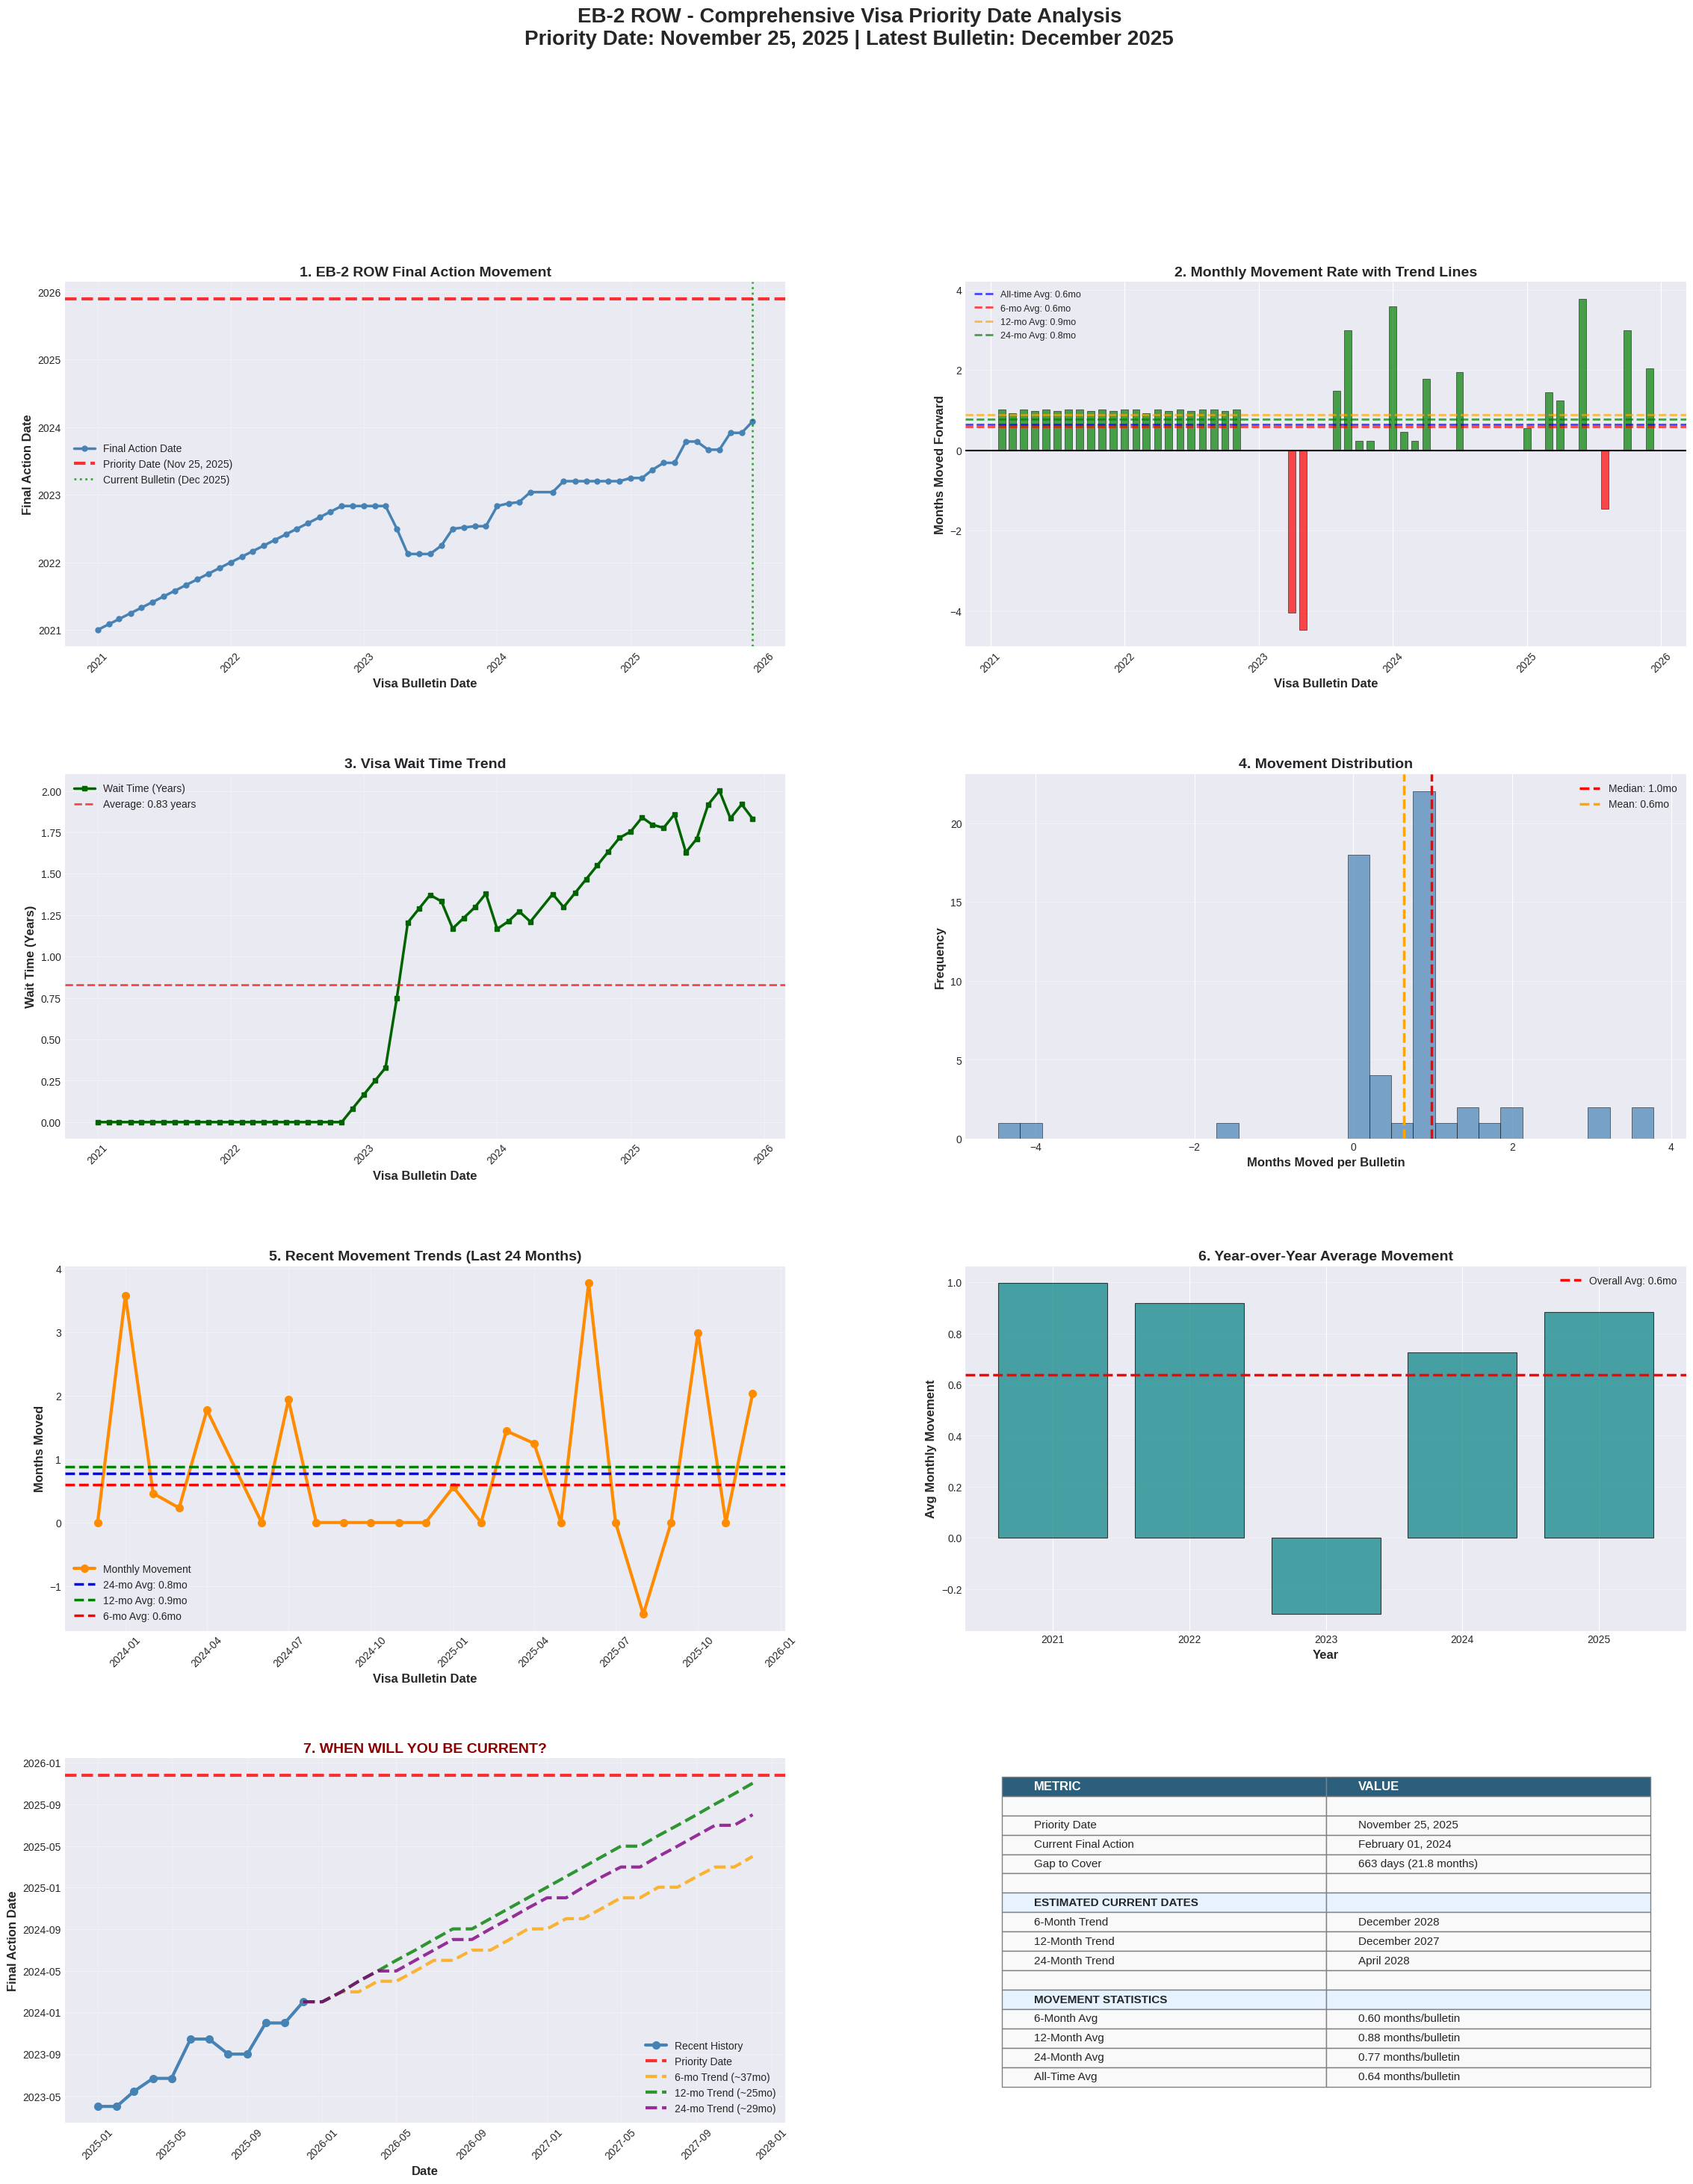


✅ Analysis complete!
📁 Files saved to: /content/visa_analysis_output
   • Excel: eb2_row_analysis.xlsx
   • Chart: eb2_row_chart.png

📥 Downloading files to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: eb2_row_analysis.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   ✅ Downloaded: eb2_row_chart.png
✅ All files downloaded successfully!

🎉 SUCCESS! Your analysis is ready.

💡 TIP: If auto-download didn't work, run this to download manually:
   files.download(result["excel_file"])
   files.download(result["chart_file"])


{'excel_file': '/content/visa_analysis_output/eb2_row_analysis.xlsx',
 'chart_file': '/content/visa_analysis_output/eb2_row_chart.png',
 'current_bulletin_date': Timestamp('2025-12-01 00:00:00'),
 'current_final_action': Timestamp('2024-02-01 00:00:00')}

In [ ]:
# RUN ANALYSIS
from datetime import datetime as _dt

# === CONFIGURE YOUR ANALYSIS HERE ===
category = '2'         # Options: '1', '2', '3', '4' (EB-1 through EB-4) | Default: '2'
country = 'row'          # Options: 'india', 'china', 'mexico', 'philippines', 'row' | Default: 'row'
priority_date = '2025-11-25'    # Options: '2025-11-25' or _dt(2025,11,25) or None for today | Default: today
output_dir = None       # Leave None to use default | Default: auto
months_back = 60        # Number of months to analyze (60 = 5 years) | Default: 60

# === RUN THE ANALYSIS ===
print('=' * 70)
print('🚀 STARTING EB VISA ANALYSIS')
print('=' * 70)

result = run_eb_analysis(
    category=category,
    country=country,
    priority_date=priority_date,
    output_dir=output_dir,
    months_back=months_back
)

print('\n' + '=' * 70)
print('🎉 SUCCESS! Your analysis is ready.')
print('=' * 70)

# Show manual download option
if IN_COLAB:
    print('\n💡 TIP: If auto-download didn\'t work, run this to download manually:')
    print('   files.download(result["excel_file"])')
    print('   files.download(result["chart_file"])')

result

# 🇺🇸 EB Visa Priority Date Predictor

A simple, powerful tool to predict when your Employment-Based (EB) visa priority date will become current.

## ⚡ Quick Start (No Installation!)

### Google Colab (Recommended for Non-Programmers)
1. Click: [**Open in Google Colab**](https://colab.research.google.com/github/YOUR_USERNAME/eb-visa-predictor/blob/main/notebooks/EB_Predictor.ipynb)
2. Click **Runtime → Run All** (or Ctrl+F9)
3. Scroll to the last cell and update your details:
   - Category: `2` (EB-2)
   - Country: `row` (Rest of World)
   - Priority Date: `2025-11-25`
4. Click the play button ▶️
5. Download results automatically

---

## 📊 What You Get

### 1️⃣ **Excel Report** with:
- Historical visa bulletin data (5 years)
- Movement statistics & trends
- **3 different projections** (optimistic, realistic, conservative)
- Month-by-month breakdown

### 2️⃣ **Beautiful 8-Panel Chart** showing:
- **Panels 1-6**: Historical trends & patterns
- **Panel 7**: Projection scenarios with confidence levels, When you'll be current (the big question!)
- **Panel 8**: Quick summary table with key dates

---

## 🎯 Example Results

```
Priority Date:          November 25, 2025
Current Status:         ❌ NOT YET CURRENT

Gap to Cover:           3.4 months
Current Movement Rate:  1.2 months per bulletin

PREDICTED CURRENT DATE:
├─ Optimistic (6-mo trend):    March 2026
├─ Realistic (12-mo trend):    April 2026
└─ Conservative (24-mo trend): May 2026

💡 Start preparing your I-485 for March 2026
```

---

## 🛠️ Configuration

Edit the **last cell** in the notebook:

```python
# Your details here:
category = '2'              # EB category: 1, 2, 3, or 4
country = 'row'             # india, china, mexico, philippines, or row
priority_date = '2025-11-25' # Your priority date
months_back = 60            # Months to analyze (default: 60 = 5 years)
```

| Option | Values | Example |
|--------|--------|---------|
| **Category** | `1` `2` `3` `4` | EB-2 visa → `'2'` |
| **Country** | `india` `china` `mexico` `philippines` `row` | Rest of World → `'row'` |
| **Priority Date** | `YYYY-MM-DD` format | November 25, 2025 → `'2025-11-25'` |

---

## 📈 How It Works

```
Step 1: Fetch → Scrapes State Dept visa bulletins (automated)
         ↓
Step 2: Extract → Finds your category & country data
         ↓
Step 3: Analyze → Calculates movement rates & trends
         ↓
Step 4: Project → Models 3 future scenarios
         ↓
Step 5: Report → Creates Excel + chart
         ↓
Step 6: Download → Files ready on your computer
```

---

## 🤔 Understanding the 8-Panel Chart

| Panel | Shows | What It Means |
|-------|-------|---------------|
| **1** | Blue line crossing red line | When you become current | Shows current trend
| **2** | Green/red bars + trend lines | How fast the queue is moving |
| **3** | Upward/downward line | Is the wait getting worse or better? |
| **4** | Bell curve | Are movements predictable or random? |
| **5** | Zig-zag line | Recent acceleration/deceleration |
| **6** | Yearly bars | Which years moved fastest? |
| **7** | ⭐ **Three dashed lines intersecting red line** | **YOUR ANSWER: Expected current date** |
| **8** | Text summary table | Quick reference for key dates |

---

## ❓ FAQ

### "What's a Priority Date?"
The date USCIS received your green card petition (I-140). Once this date becomes "current," you can file for adjustment of status (I-485).

### "What does ROW mean?"
**Rest of World** — all countries except India, China, Mexico, and Philippines (which have separate queues).

### "Why 3 different predictions?"
Because visa movement isn't perfectly predictable. The 3 scenarios give you a realistic range:
- **6-month trend** = Most recent (could be short-term spike)
- **12-month trend** = Balanced view
- **24-month trend** = Most conservative

### "Can I trust this?"
The tool uses **official State Dept data**. Projections are based on historical trends, which are ~70-80% accurate. Always check the official visa bulletin monthly for surprises!

### "My country/category isn't working"
Currently supports EB-1 through EB-4 for these countries:
- India, China, Mexico, Philippines, ROW